# [LEARN THE BASIC](https://pytorch.org/tutorials/beginner/basics/intro.html)

We’ll use the FashionMNIST dataset to train a neural network that predicts if an input image belongs to one of the following classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, or Ankle boot.

# QUICKSTART

## Working with data

PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html): `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html), [TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html), all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

In this tutorial, we use the FashionMNIST dataset. Every TorchVision `Dataset` includes two arguments: `transform` and `target_transform` to modify the samples and labels respectively.

In [2]:
# Download training data from open datasets
traininig_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
)

# Download test data from open datasets
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)

100%|██████████| 26421880/26421880 [00:12<00:00, 2116555.76it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 99788.31it/s] 


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1631046.28it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19882391.34it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We pass the Dataset as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. 

In [3]:
batch_size = 64

# create data loaders
train_dataloader = DataLoader(traininig_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Read more about [loading data in PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

## Creating Models

To define a neural network in PyTorch, we create a class that inherits from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network in the `__init__` function and specify how data will pass through the network in the `forward` function. To accelerate operations in the neural network, we move it to the GPU or MPS if available.


In [4]:
# Get cpu, gpu or mps device for training

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using mps device


In [5]:
# Define model
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Read more about [building neural networks in PyTorch](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

## Optimizing the MOdel Parameters

To train a model, we need a `loss function` and an `optimizer`.

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:<5d}/{size:>5d}]")

We also check the model’s performance against the test dataset to ensure it is learning

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

In [9]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
---------------------------------


loss: 2.303615 [64   /60000]
loss: 2.291518 [6464 /60000]
loss: 2.271068 [12864/60000]
loss: 2.267827 [19264/60000]
loss: 2.250052 [25664/60000]
loss: 2.218151 [32064/60000]
loss: 2.227829 [38464/60000]
loss: 2.195369 [44864/60000]
loss: 2.191664 [51264/60000]
loss: 2.152938 [57664/60000]
Test Error: 
 Accuracy: 36.7%, Avg loss: 2.149207

Epoch 2
---------------------------------
loss: 2.159222 [64   /60000]
loss: 2.150055 [6464 /60000]
loss: 2.087400 [12864/60000]
loss: 2.109083 [19264/60000]
loss: 2.052209 [25664/60000]
loss: 1.993713 [32064/60000]
loss: 2.027394 [38464/60000]
loss: 1.949266 [44864/60000]
loss: 1.957227 [51264/60000]
loss: 1.874753 [57664/60000]
Test Error: 
 Accuracy: 57.1%, Avg loss: 1.871812

Epoch 3
---------------------------------
loss: 1.910338 [64   /60000]
loss: 1.874721 [6464 /60000]
loss: 1.752771 [12864/60000]
loss: 1.800883 [19264/60000]
loss: 1.681738 [25664/60000]
loss: 1.642085 [32064/60000]
loss: 1.669104 [38464/60000]
loss: 1.573136 [44864/60000]
lo

## Saving Models

A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [10]:
torch.save(model.state_dict(), "./models/model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [11]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("./models/model.pth"))

<All keys matched successfully>

In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [14]:
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# TENSORS

Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other hardware accelerators. In fact, tensors and NumPy arrays can often share the same underlying memory, eliminating the need to copy data (see Bridge with NumPy). Tensors are also optimized for automatic differentiation (we’ll see more about that later in the Autograd section). If you’re familiar with ndarrays, you’ll be right at home with the Tensor API. If not, follow along!

In [15]:
import torch
import numpy as np

## Initializing a Tensor

Tensors can be initialized in various ways. Take a look at the following examples:

### Directly from data

Tensors can be created directly from data. The data type is automatically inferred.

In [16]:
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)
x_data

tensor([[1, 2],
        [3, 4]])

### From a Numpy array

Tensors can be created from NumPy arrays (and vice versa - see [Bridge with NumPy](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#bridge-to-np-label)).

In [17]:
x_ones = torch.ones_like(x_data)    # retain the properties of x_data
print(f"Ones Tensor: \n {x_ones}\n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand}\n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]])

Random Tensor: 
 tensor([[0.0692, 0.7928],
        [0.5761, 0.5878]])



### With random or constant values

`shape` is a tuple of tensor dimensions. In the functions below, it determines the dimensionality of the output tensor.

In [18]:
shape = (2, 3)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zerors_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor}\n")
print(f"Ones Tensor: \n {ones_tensor}\n")
print(f"Zeroes Tensor: \n {zerors_tensor}")

Random Tensor: 
 tensor([[0.5308, 0.9190, 0.0113],
        [0.9259, 0.8529, 0.6850]])

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]])

Zeroes Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


## Attributes of a Tensor

In [19]:
tensor = torch.rand(3, 4)

print(f"Shape of tensor : {tensor.shape}")
print(f"Datatype of tensor : {tensor.dtype}")
print(f"Device tensor is stoed on: {tensor.device}")

Shape of tensor : torch.Size([3, 4])
Datatype of tensor : torch.float32
Device tensor is stoed on: cpu


## Operations on Tensors

Over 100 tensor operations, including arithmetic, linear algebra, matrix manipulation (transposing, indexing, slicing), sampling and more are comprehensively described [here](https://pytorch.org/docs/stable/torch.html).

By default, tensors are created on the CPU. We need to explicitly move tensors to the GPU using .to method (after checking for GPU availability). Keep in mind that copying large tensors across devices can be expensive in terms of time and memory!

In [20]:
# we move our tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

elif torch.backends.mps.is_available():
    tensor = tensor.to("mps")

Try out some of the operations from the list. If you’re familiar with the NumPy API, you’ll find the Tensor API a breeze to use.

### Standard numpy-like indexing and slicing

In [21]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:, 1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


<b>Joining tensors</b> You can use `torch.cat` to concatenate a sequence of tensors along a given dimension. See also [torch.stack](https://pytorch.org/docs/stable/generated/torch.stack.html), another tensor joining operator that is subtly different from `torch.cat`.

In [22]:
t1 = torch.concat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


### Arithmetic operations

In [24]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# `tensor.T` returns the transpose of a tnesor
y1 = tensor @ tensor.T
y1

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])

In [26]:
y2 = tensor.matmul(tensor.T)
y2

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])

In [28]:
y3 = torch.rand_like(y1)
print(y3)
torch.matmul(tensor, tensor.T, out=y3)
y3

tensor([[0.4713, 0.7177, 0.3578, 0.3548],
        [0.8986, 0.2669, 0.9555, 0.7196],
        [0.3832, 0.2804, 0.3189, 0.5872],
        [0.1476, 0.4394, 0.1697, 0.1194]])


tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])

In [29]:
# This computes the element-wise product, z1, z2, z3 will have the same value
z1 = tensor * tensor
z1

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [30]:
z2 = tensor.mul(tensor)
z2

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [31]:
z3 = torch.rand_like(tensor)
print(z3)
torch.mul(tensor, tensor, out=z3)
z3

tensor([[0.9886, 0.8037, 0.9447, 0.5412],
        [0.0244, 0.7785, 0.6969, 0.4257],
        [0.0056, 0.0792, 0.0073, 0.7830],
        [0.8329, 0.3824, 0.4602, 0.2665]])


tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

<b>Single-element tensors</b> If you have a one-element tensor, for example by aggregating all values of a tensor into one value, you can convert it to a Python numerical value using `item()`:

In [32]:
agg = tensor.sum()
agg

tensor(12.)

In [33]:
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


<b>In-place operations</b> Operations that store the result into the operand are called in-place. They are denoted by a `_` suffix. For example: `x.copy_(y)`, `x.t_()`, will change x.

In [34]:
print(f'{tensor} \n')
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


## Bridge with NumPy

Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other.

### Tensor to NumPy array

In [36]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


A change in the tensor reflects in the NumPy array.

In [39]:
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


### Numpy array to Tensor

In [40]:
n = np.ones(5)
t = torch.from_numpy(n)

Changes in the Numpy array reflects in the tensor.

In [41]:
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


# DATASETS & DATALOADERS


Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples.

## Loding a Dataset

We load the `FashionMNIST` Dataset with the following parameters:
    
- `root` is the path where the train/test data is stored,

- `train` specifies training or test dataset,

- `download=True` downloads the data from the internet if it’s not available at `root`.

- `transform` and `target_transform` specify the feature and label transformations

In [44]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [47]:
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

## Iterating and Visualizing the Dataset

We can index `Datasets` manually like a list: `training_data[index]`. We use `matplotlib` to visualize some samples in our training data.

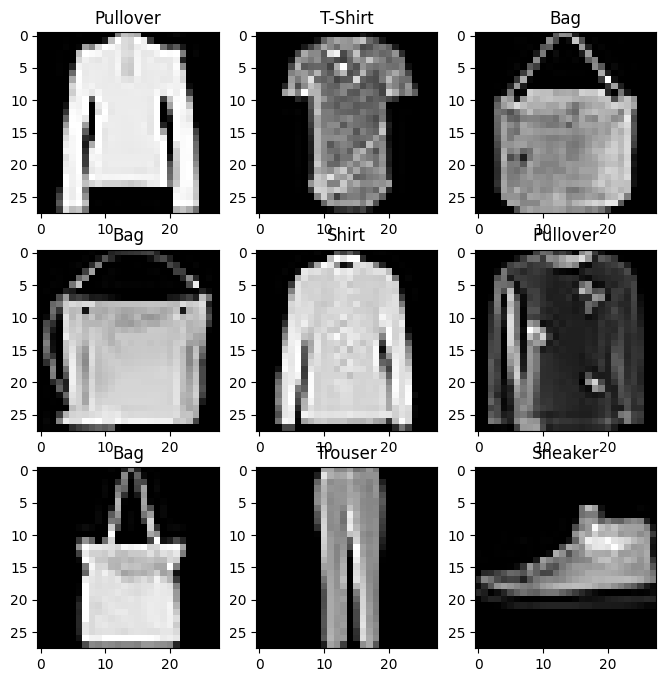

In [48]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

## Creating a Custom Dataset for yout files

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the FashionMNIST images are stored in a directory `img_dir`, and their labels are stored separately in a CSV file annotations_file.

In [49]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

### `__init__`

The `__init__` function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).

The labels.csv file looks like:
```
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```

### `__len__`

The __len__ function returns the number of samples in our dataset.

### `__getitem__`

The __getitem__ function loads and returns a sample from the dataset at the given index `idx`. Based on the index, it identifies the image’s location on disk, converts that to a tensor using `read_image`, retrieves the corresponding label from the csv data in `self.img_labels`, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

## Preparing yout data for training with DataLoaders

The `Dataset` retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s `multiprocessing` to speed up data retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an easy API.

In [50]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader


We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration below returns a batch of `train_features` and `train_labels` (containing `batch_size=64` features and `labels` respectively). Because we specified `shuffle=True`, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at Samplers).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


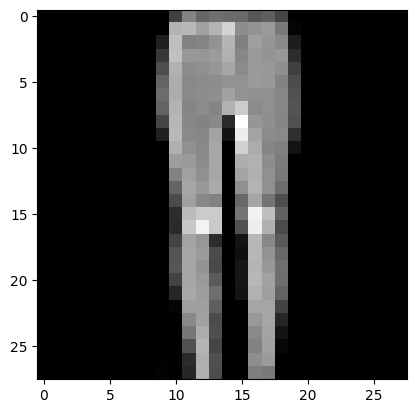

Label: 1


In [52]:
# display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# TRANSFORMS

Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic.

The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use `ToTensor` and `Lambda`.

In [53]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

## ToTensor()

`ToTensor` converts a PIL image or NumPy `ndarray` into a `FloatTensor`. and scales the image’s pixel intensity values in the range [0., 1.]

## Lambda Transforms

Lambda transforms apply any user-defined lambda function. Here, we define a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls `scatter_` which assigns a `value=1` on the index as given by the label `y`.

# BUILD THE NEURAL NETWORK

Neural networks comprise of layers/modules that perform operations on data. The `torch.nn` namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the `nn.Module`.

In [55]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Get Device for Training

We want to be able to train our model on a hardware accelerator like the GPU or MPS, if available. Let’s check to see if `torch.cuda` or `torch.backends.mps` are available, otherwise we use the CPU.

In [56]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using mps device


## Define the class

We define our neural network by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the `forward` method.

In [57]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of `NeuralNetwork`, and move it to the `device`, and print its structure.

In [58]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model’s `forward`, along with some background operations. Do not call model.`forward()` directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output. We get the prediction probabilities by passing it through an instance of the `nn.Softmax` module.

In [68]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
logits

tensor([[ 0.0492, -0.1140, -0.0434, -0.0607,  0.0037,  0.0642,  0.0833,  0.0064,
         -0.0074,  0.1047]], device='mps:0', grad_fn=<LinearBackward0>)

In [69]:
pred_probab = nn.Softmax(dim=1)(logits)
pred_probab

tensor([[0.1039, 0.0883, 0.0947, 0.0931, 0.0993, 0.1055, 0.1075, 0.0996, 0.0982,
         0.1099]], device='mps:0', grad_fn=<SoftmaxBackward0>)

In [70]:
y_pred = pred_probab.argmax(1)
print(f"Predicted class : {y_pred}")

Predicted class : tensor([9], device='mps:0')


## Model Layers

Let’s break down the layers in the FashionMNIST model. To illustrate it, we will take a sample minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network.

In [71]:
input_image = torch.rand(3, 28, 28)
print(input_image.size())

torch.Size([3, 28, 28])


### `nn.Flatten`

We initialize the `nn.Flatten` layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).

In [72]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### `nn.Linear`

The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.

In [73]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### `nn.ReLU`

Non-linear activations are what create the complex mappings between the model’s inputs and outputs. They are applied after linear transformations to introduce nonlinearity, helping neural networks learn a wide variety of phenomena.

In [74]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.4513,  0.3472,  0.2899,  0.1405, -0.1592,  0.3686, -0.0817,  0.0915,
          0.4298, -0.1804, -0.2040,  0.0471, -0.2202, -0.3114, -0.2953,  0.0723,
         -0.4549,  0.3002,  0.3495,  0.2312],
        [ 0.2196,  0.1732,  0.2381, -0.0378, -0.1332,  0.1890, -0.1802, -0.3016,
         -0.1623, -0.3211,  0.1253, -0.2278, -0.6238, -0.1193, -0.2010, -0.2368,
         -0.5616,  0.3926,  0.1319,  0.4437],
        [ 0.2461,  0.2231,  0.2967,  0.1846,  0.0008,  0.2604, -0.2156, -0.1674,
          0.1780, -0.1801, -0.3485,  0.1046, -0.2577, -0.3074, -0.0721, -0.0406,
         -0.0438,  0.2466,  0.0332,  0.0567]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.4513, 0.3472, 0.2899, 0.1405, 0.0000, 0.3686, 0.0000, 0.0915, 0.4298,
         0.0000, 0.0000, 0.0471, 0.0000, 0.0000, 0.0000, 0.0723, 0.0000, 0.3002,
         0.3495, 0.2312],
        [0.2196, 0.1732, 0.2381, 0.0000, 0.0000, 0.1890, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1253, 0.0000, 0.0000, 0.0000, 0.00

### `nn.Sequential`

`nn.Sequential` is an ordered container of modules. The data is passed through all the modules in the same order as defined. You can use sequential containers to put together a quick network like `seq_modules`.

In [75]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)

In [76]:
input_image = torch.rand(3, 28, 28)
logits = seq_modules(input_image)

### `nn.Softmax`

The last linear layer of the neural network returns logits - raw values in [-infty, infty] - which are passed to the `nn.Softmax` module. The logits are scaled to values [0, 1] representing the model’s predicted probabilities for each class. `dim` parameter indicates the dimension along which the values must sum to 1.

In [77]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)
pred_probab

tensor([[0.0870, 0.1088, 0.0980, 0.1216, 0.1004, 0.0913, 0.0801, 0.0955, 0.1190,
         0.0982],
        [0.0835, 0.1138, 0.0925, 0.1328, 0.1047, 0.1095, 0.0794, 0.0778, 0.0985,
         0.1073],
        [0.0801, 0.1248, 0.0943, 0.1266, 0.1014, 0.1005, 0.0829, 0.0764, 0.1055,
         0.1075]], grad_fn=<SoftmaxBackward0>)

## Model Parameters

Many layers inside a neural network are parameterized, i.e. have associated weights and biases that are optimized during training. Subclassing nn.Module automatically tracks all fields defined inside your model object, and makes all parameters accessible using your model’s `parameters()` or `named_parameters()` methods.

In [78]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]}\n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[-0.0121,  0.0315, -0.0033,  ..., -0.0209,  0.0056,  0.0213],
        [ 0.0356, -0.0331, -0.0175,  ...,  0.0343,  0.0148,  0.0012]],
       device='mps:0', grad_fn=<SliceBackward0>)

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([ 0.0275, -0.0331], device='mps:0', grad_fn=<SliceBackward0>)

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values: tensor([[ 0.0036, -0.0006,  0.0228,  ...,  0.0379, -0.0207, -0.0016],
        [-0.0262,  0.0397, -0.0122,  ..., -0.0374,  0.0122,  0.0111]],
       device='mps:0', grad_fn=<SliceBackw

# AUTOMATIC DIFFERENTIATION WITH `TORCH.AUTOGRAD`

When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called torch.autograd. It supports automatic computation of gradient for any computational graph.

Consider the simplest one-layer neural network, with input `x`, parameters `w` and `b`, and some loss function. It can be defined in PyTorch in the following manner:

In [79]:
import torch

x = torch.ones(5)       # input tensor
y = torch.zeros(3)      # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

## Tensors, Functions and Computational graph

<img src="https://pytorch.org/tutorials/_images/comp-graph.png">

In this network, `w` and `b` are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the `requires_grad` property of those tensors.

You can set the value of requires_grad when creating a tensor, or later by using `x.requires_grad_(True)` method.

A function that we apply to tensors to construct computational graph is in fact an object of class `Function`. This object knows how to compute the function in the forward direction, and also how to compute its derivative during the backward propagation step. A reference to the backward propagation function is stored in `grad_fn` property of a tensor.

In [80]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x29b47a0d0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x29b47a070>


## Computing Gradients

o optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters, namely, we need $\frac{\partial loss}{\partial w}$ and $\frac{\partial loss}{\partial b}$ user some fixed values of `x` and `y`. To compute those derivatives, we call loss.backward(), and then retrieve the values from `w.grad` and `b.grad`:

In [81]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0288, 0.1071, 0.0501],
        [0.0288, 0.1071, 0.0501],
        [0.0288, 0.1071, 0.0501],
        [0.0288, 0.1071, 0.0501],
        [0.0288, 0.1071, 0.0501]])
tensor([0.0288, 0.1071, 0.0501])


We can only obtain the `grad` properties for the leaf nodes of the computational graph, which have `requires_grad` property set to True. For all other nodes in our graph, gradients will not be available.

We can only perform gradient calculations using `backward` once on a given graph, for performance reasons. If we need to do several backward calls on the same graph, we need to pass `retain_graph=True` to the backward call.

## Disabling Gradient Tracking

By default, all tensors with `requires_grad=True` are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. We can stop tracking computations by surrounding our computation code with torch.`no_grad()` block:

In [82]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


Another way to achieve the same result is to use the `detach()` method on the tensor:

In [83]:
z = torch.matmul(x, w) + b
z_det = z.detach()
print(z_det.requires_grad)

False


## More on Computational Graphs

Conceptually, autograd keeps a record of data (tensors) and all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

- run the requested operation to compute a resulting tensor

- maintain the operation’s gradient function in the DAG.

The backward pass kicks off when `.backward()` is called on the DAG root. `autograd` then:

- computes the gradients from each ``.grad_fn`,

- accumulates them in the respective tensor’s `.grad` attribute

- using the chain rule, propagates all the way to the leaf tensors.


## Tensor Gradients and Jacobian Products

In many cases, we have a scalar loss function, and we need to compute the gradient with respect to some parameters. However, there are cases when the output function is an arbitrary tensor. In this case, PyTorch allows you to compute so-called Jacobian product, and not the actual gradient.

For a vector function $\vec{y}=f(\vec{x})$, where $\vec{x}=<x_1,...,x_n>$ and $\vec{y}=<y_1,...,y_m>$, a gradient of $\vec{y}$ with respect to $\vec{x}$ is given by <b>Jacobian matrix</b>:

$$J=\begin{pmatrix} \frac{\partial y_1}{\partial x_1} & \cdots & \frac{\partial y_1}{\partial x_n}\\
\vdots & \ddots & \vdots\\
\frac{\partial y_m}{\partial x_1} & \cdots & \frac{\partial y_m}{\partial x_n}\end{pmatrix}$$

Instead of computing the Jacobian matrix itself, PyTorch allows you to compute <b>Jacobian Product</b> $v^T$. $J$ for a given input vector $ v = (v_1,...,v_m)$. This is achieved by calling `backward` as an argument. The size of `v` should be the same as the size of the original tensor, with respect to which we want to compute the product:

In [87]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n {inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
 tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


# OPTIMIZING MODEL PARAMETERS